# Convolutional Neural Network for MNIST Classification

The dataset is called MNIST and refers to handwritten digit recognition. You can find more about it on Yann LeCun's website (Director of AI Research, Facebook).

The dataset provides 70,000 images (28x28 pixels) of handwritten digits (1 digit per image).

The goal is to write an algorithm that detects which digit is written. Since there are only 10 digits (0, 1, 2, 3, 4, 5, 6, 7, 8, 9), this is a classification problem with 10 classes.

Our goal would be to build a convolutional neural network with hidden layers and channels.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import keras_tuner as kt
import tensorflow_datasets as tfds
import random

## Data Preprocessing

In [22]:
def Preprocess_MNIST(BUFFER_SIZE=10000, BATCH_SIZE=100):
    """
    This BUFFER_SIZE parameter is here for cases when we're dealing with enormous datasets, 
    then we can't shuffle the whole dataset in one go because we can't fit it all in memory, 
    so instead TF only stores BUFFER_SIZE samples in memory at a time and shuffles them.
    
    if BUFFER_SIZE = 1 -- no shuffling will actually happen
    if BUFFER_SIZE >= num samples -- shuffling is uniform
    BUFFER_SIZE in between -- a computational optimization to approximate uniform shuffling
    
    # BUFFER_SIZE = 10000 Default

    The batch size for batching the training data during training
    # BATCH_SIZE = 100 Default
    """
    
    # Load the data from tfds
    mnist_datasets, mnist_info = tfds.load(name='mnist', with_info=True, as_supervised=True)
    
    # with_info=True will also provide us with a tuple containing information about the version, features, number of samples
    # as_supervised=True will load the dataset in a 2-tuple structure (input, target)
    
    # once we have loaded the dataset, we can easily extract the training and testing dataset
    mnist_train, mnist_test = mnist_datasets['train'], mnist_datasets['test']
    
    # we start by defining the number of validation samples as a % of the train samples
    num_validation_samples = 0.1 * mnist_info.splits["train"].num_examples
    # let's cast this number to an integer, as a float may cause an error along the way
    num_validation_samples = tf.cast(num_validation_samples, tf.int64)
    
    # let's also store the number of test samples in a dedicated variable
    num_test_samples = tf.cast(mnist_info.splits['test'].num_examples, tf.int64)
    
    # let's define a lamda function called: scale, that will take an MNIST image and its label
    # since the possible values for the inputs are 0 to 255 (256 different shades of grey)
    # if we divide each element by 255, we would get the desired result -> all elements will be between 0 and 1
    scale = lambda x, y: (tf.cast(x, tf.float32) / 255., y)
    
    # we will apply the scaling transformation on the mnist_train and store it as both train and validation data
    scaled_train_and_validation_data = mnist_train.map(scale)
    # same thing for the test data so it has the same magnitude as the train and validation
    scaled_test_data = mnist_test.map(scale)
    
    # We will also shuffle the combine train and validation data.
    # There is no need to shuffle the test data, because we won't be training on it.
    # there is a shuffle method readily available and we just need to specify the buffer size
    shuffled_train_and_validation_data = scaled_train_and_validation_data.shuffle(buffer_size=BUFFER_SIZE, seed=42)
    
    # once we have scaled and shuffled the data, we can proceed to actually extracting the train and validation
    # our validation data would be equal to 10% of the training set, which we've already calculated
    # we use the .take() method to take that many samples
    validation_data = shuffled_train_and_validation_data.take(num_validation_samples)
    
    # similarly, the train_data is everything else, so we skip as many samples as there are in the validation dataset
    train_data = shuffled_train_and_validation_data.skip(num_validation_samples)
    
    # batch the data
    train_data = train_data.batch(BATCH_SIZE)
    
    validation_data = validation_data.batch(num_validation_samples)
    
    test_data = scaled_test_data.batch(num_test_samples)
    
    # takes next batch (it is the only batch)
    # because as_supervized=True, we've got a 2-tuple structure
    validation_inputs, validation_targets = next(iter(validation_data))
    
    return train_data, validation_data, test_data

In [24]:
train_data, validation_data, test_data = Preprocess_MNIST()
print(train_data)
print(validation_data)
print(test_data)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


### Preparation
- The MNIST dataset contains 70,000 grayscale images (28×28 pixels) of handwritten digits (0-9)
- Data split: 60,000 training samples with 10% (6,000) used for validation, and 10,000 test samples
- Images were scaled from 0-255 to 0-1 range for numerical stability
- Data was shuffled with a fixed seed (42) to ensure reproducibility

## Model using CNN

In [118]:
# Define a CNN model for MNIST
def create_cnn_model():
    model = keras.Sequential([
        # Input layer - reshape not needed, data is already in shape (28, 28, 1)
        
        # First Convolutional Block
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        # Second Convolutional Block
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        # Third Convolutional Block (deeper feature extraction)
        keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        # Flatten the output to feed into dense layers
        keras.layers.Flatten(),
        
        # Fully connected layers
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),  # Adding dropout for regularization
        
        # Output layer
        keras.layers.Dense(10, activation='softmax')
    ])
    
    # Compile the model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [119]:
# Create the model object
cnn_model = create_cnn_model()
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 3, 3, 128)        

### Train the CNN model

In [121]:
# Create a callback for tracking metrics
class MetricsHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.losses = []
        self.val_losses = []
        self.accuracy = []
        self.val_accuracy = []
    
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accuracy.append(logs.get('accuracy'))
        self.val_accuracy.append(logs.get('val_accuracy'))

# Create an instance of the callback
metrics_history = MetricsHistory()

# Adding model checkpoint to save the best model
checkpoint = ModelCheckpoint(
    'cnn_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Adding early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# specify the number of epochs
EPOCHS = 20

# takes next batch (it is the only batch)
# because as_supervized=True, we've got a 2-tuple structure
validation_inputs, validation_targets = next(iter(validation_data))

# we fit the model, specifying the training data, the total number of epochs, callbacks
cnn_model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=(validation_inputs, validation_targets),
    callbacks=[metrics_history, checkpoint, early_stopping],
    verbose=2
)


Epoch 1/20

Epoch 1: val_accuracy improved from -inf to 0.98183, saving model to cnn_model.h5
540/540 - 18s - loss: 0.3013 - accuracy: 0.9050 - val_loss: 0.0633 - val_accuracy: 0.9818 - 18s/epoch - 33ms/step
Epoch 2/20


C:\Users\josep\anaconda3\envs\TF2.0\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_accuracy improved from 0.98183 to 0.98700, saving model to cnn_model.h5
540/540 - 18s - loss: 0.0877 - accuracy: 0.9745 - val_loss: 0.0436 - val_accuracy: 0.9870 - 18s/epoch - 33ms/step
Epoch 3/20

Epoch 3: val_accuracy improved from 0.98700 to 0.99050, saving model to cnn_model.h5
540/540 - 18s - loss: 0.0628 - accuracy: 0.9813 - val_loss: 0.0346 - val_accuracy: 0.9905 - 18s/epoch - 33ms/step
Epoch 4/20

Epoch 4: val_accuracy did not improve from 0.99050
540/540 - 17s - loss: 0.0474 - accuracy: 0.9865 - val_loss: 0.0325 - val_accuracy: 0.9903 - 17s/epoch - 32ms/step
Epoch 5/20

Epoch 5: val_accuracy improved from 0.99050 to 0.99200, saving model to cnn_model.h5
540/540 - 17s - loss: 0.0395 - accuracy: 0.9883 - val_loss: 0.0267 - val_accuracy: 0.9920 - 17s/epoch - 32ms/step
Epoch 6/20

Epoch 6: val_accuracy improved from 0.99200 to 0.99267, saving model to cnn_model.h5
540/540 - 17s - loss: 0.0351 - accuracy: 0.9892 - val_loss: 0.0245 - val_accuracy: 0.9927 - 17s/epoch - 

In [122]:
# Print out the last value on the training and validation accuracy
print("\nValidation accuracies:")
print("----------------------------------")
print(metrics_history.val_accuracy)
print('\nBest validation accuracy: {:.2f}%'.format(checkpoint.best * 100))
print(f'\nFinal validation accuracy: {metrics_history.val_accuracy[EPOCHS-1]*100:.2f}%')


Validation accuracies:
----------------------------------
[0.9818333387374878, 0.9869999885559082, 0.9904999732971191, 0.9903333187103271, 0.9919999837875366, 0.9926666617393494, 0.9944999814033508, 0.9931666851043701, 0.9921666383743286, 0.9936666488647461, 0.9955000281333923, 0.9951666593551636, 0.9973333477973938, 0.996666669845581, 0.9971666932106018, 0.9980000257492065, 0.9980000257492065, 0.9983333349227905, 0.9975000023841858, 0.9976666569709778]

Best validation accuracy: 99.83%

Final validation accuracy: 99.77%


In [123]:
# Plot the training and validation metrics
def plot_metrics(history):
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plotting the loss metrics on the first subplot
    ax1.plot(history.losses, label='Training Loss')
    ax1.plot(history.val_losses, label='Validation Loss')
    ax1.set_title('CNN Model Loss Over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Plotting the accuracy metrics on the second subplot
    ax2.plot(history.accuracy, label='Training Accuracy')
    ax2.plot(history.val_accuracy, label='Validation Accuracy')
    ax2.set_title('CNN Model Accuracy Over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    # Display the plots
    plt.tight_layout()
    plt.show()

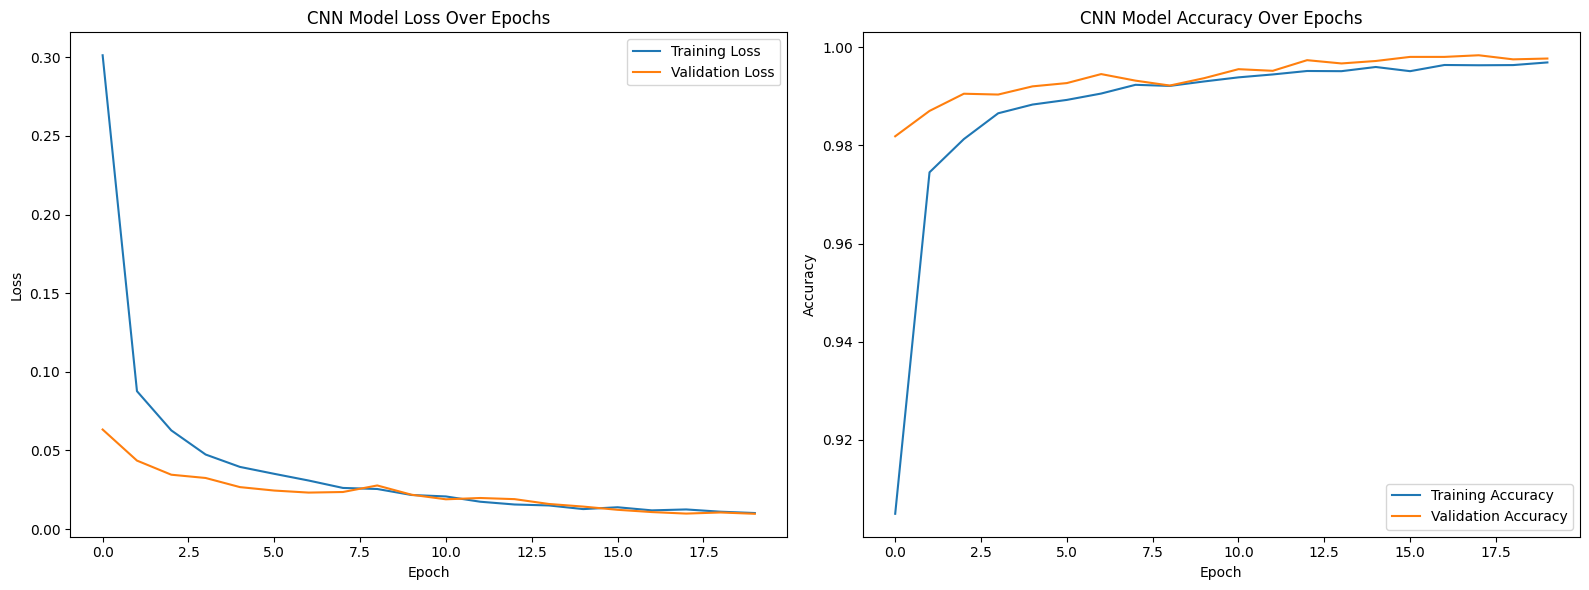

In [124]:
plot_metrics(metrics_history)

## Testing the Model

In [139]:
# Evaluate the model on test data
test_loss, test_accuracy = cnn_model.evaluate(test_data, verbose=2)
print('test loss: {:.4f}. test accuracy: {:.2f}%'.format(test_loss, test_accuracy*100.))

1/1 - 1s - loss: 0.0331 - accuracy: 0.9929 - 720ms/epoch - 720ms/step
test loss: 0.0331. test accuracy: 99.29%


### Results
- Base model: 99.63% training accuracy
- Base model: 99.83% validation accuracy
- Base model: 99.29% test accuracy 

In [145]:
# Using the Best val accuracy model
opt_cnn_model = keras.models.load_model('cnn_model.h5')
test_loss, test_accuracy = opt_cnn_model.evaluate(test_data, verbose=2)
print('test loss: {:.4f}. test accuracy: {:.2f}%'.format(test_loss, test_accuracy*100.))

1/1 - 1s - loss: 0.0276 - accuracy: 0.9930 - 823ms/epoch - 823ms/step
test loss: 0.0276. test accuracy: 99.30%


## CNN Based model

Why CNNs are better for MNIST classification:

1. Local Feature Recognition: CNNs use convolutional filters to identify local patterns like edges, 
   corners, and textures that are important for digit recognition.

2. Spatial Hierarchy: The combination of convolutional and pooling layers creates a hierarchy of 
   features from simple to complex, which helps in understanding the spatial relationships in digits.

3. Parameter Efficiency: CNNs share weights across the image, drastically reducing parameters 
   compared to fully connected networks while maintaining high performance.

4. Translation Invariance: Max pooling provides some invariance to small translations, which helps
   recognize digits regardless of their exact position in the image.

5. Performance: CNNs consistently outperform traditional MLPs on image classification tasks,
   including MNIST, often achieving >99% accuracy with proper tuning.

In [ ]:
## Save the CNN base model

In [142]:
# Save the CNN model
cnn_model.save('mnist_cnn_model.h5')
print("Model saved in h5 format")

Model saved in h5 format


## Predicting using the CNN Model on selected samples from the MNIST test data

1/1 [==============================] - 0s 88ms/step


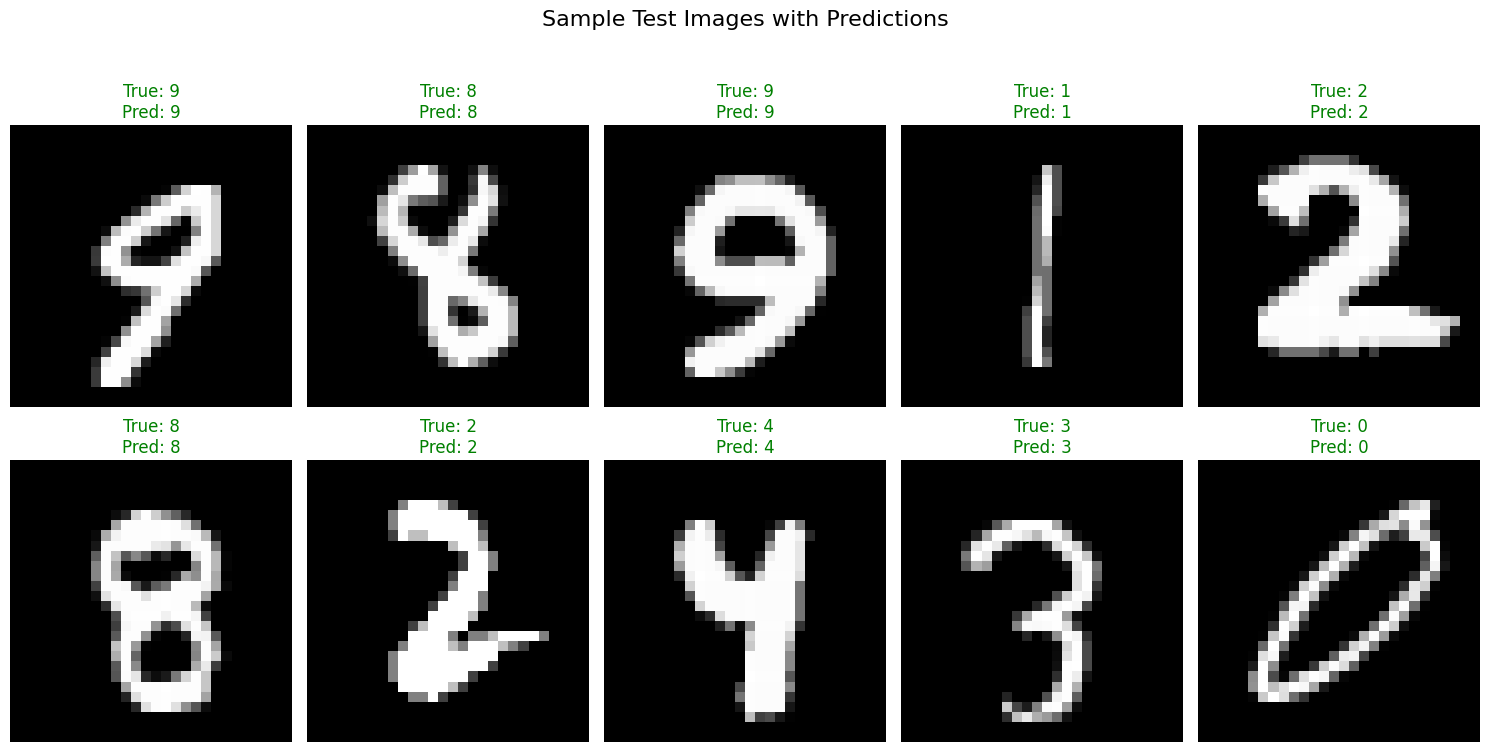

In [149]:
# Get the test dataset as NumPy arrays
test_images = []
test_labels = []

# Take the first batch from test_data, since our test data was batch 
# based on all the test samples, this result in 10,000 batch of data
for images, labels in test_data.take(1):
    test_images = images.numpy()
    test_labels = labels.numpy()

# Select a random subset of images
num_samples = 10
sample_indices = random.sample(range(len(test_images)), num_samples)
sample_images = test_images[sample_indices]
sample_labels = test_labels[sample_indices]

# Make predictions on the sample images
predictions = cnn_model.predict(sample_images)
predicted_labels = np.argmax(predictions, axis=1)

# Plot the sample images with their true and predicted labels
plt.figure(figsize=(15, 8))
for i in range(num_samples):
    plt.subplot(2, 5, i+1)
    
    # Reshape and display the image (removing the channel dimension)
    plt.imshow(sample_images[i].reshape(28, 28), cmap='gray')
    
    # Display true and predicted labels
    title_color = 'green' if predicted_labels[i] == sample_labels[i] else 'red'
    plt.title(f"True: {sample_labels[i]}\nPred: {predicted_labels[i]}", 
              color=title_color)
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Sample Test Images with Predictions", fontsize=16)
plt.subplots_adjust(top=0.88)
plt.show()


## Predicting using the CNN Model on handwritten digit

In [156]:
import cv2
import PIL
from PIL import Image

def preprocess_handwritten_digit(image_path):
    """
    Preprocess a handwritten digit image to match MNIST format:
    - Convert to grayscale
    - Resize to 28x28 pixels
    - Invert if needed (MNIST has white digits on black background)
    - Normalize pixel values to range [0,1]
    """
    # Read the image
    img = cv2.imread(image_path)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to reduce noise (optional but helpful)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply thresholding to get a binary image
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    
    # Find contours to center the digit
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        # Find the largest contour (should be the digit)
        cnt = max(contours, key=cv2.contourArea)
        
        # Get bounding box for the digit
        x, y, w, h = cv2.boundingRect(cnt)
        
        # Create a square bounding box (to maintain aspect ratio)
        size = max(w, h)
        
        # Add some padding
        padding = int(size * 0.2)
        size += padding * 2
        
        # Calculate the new center
        center_x = x + w // 2
        center_y = y + h // 2
        
        # Define the new square bounding box
        x1 = max(0, center_x - size // 2)
        y1 = max(0, center_y - size // 2)
        x2 = min(thresh.shape[1], x1 + size)
        y2 = min(thresh.shape[0], y1 + size)
        
        # Extract the digit
        digit = thresh[y1:y2, x1:x2]
        
        # Resize to 28x28 pixels
        digit = cv2.resize(digit, (28, 28), interpolation=cv2.INTER_AREA)
    else:
        # If no contours found, just resize the whole image
        digit = cv2.resize(thresh, (28, 28), interpolation=cv2.INTER_AREA)
    
    # Normalize pixel values to [0,1]
    digit = digit.astype('float32') / 255.0

    
    # Display the processed image
    plt.figure(figsize=(5, 5))
    plt.imshow(digit, cmap='gray')
    plt.title("Processed Handwritten Digit")
    plt.axis('off')
    plt.show()
    
    return digit


def predict_digit(model, preprocessed_digit):
    """
    Make a prediction using the model
    """
    # Reshape to match model input shape: (1, 28, 28, 1)
    sample = preprocessed_digit.reshape(1, 28, 28, 1)
    
    # Get prediction
    prediction = model.predict(sample)[0]
    predicted_digit = np.argmax(prediction)
    confidence = prediction[predicted_digit] * 100

    # Display the prediction
    print(f"Predicted digit: {predicted_digit}")
    print(f"Confidence: {confidence:.2f}%")
    
    # Plot the prediction probabilities
    plt.figure(figsize=(10, 4))
    plt.bar(range(10), prediction)
    plt.xticks(range(10))
    plt.xlabel('Digit')
    plt.ylabel('Probability')
    plt.title(f'Prediction probabilities (Predicted: {predicted_digit}, Confidence: {confidence:.2f}%)')
    plt.ylim(0, 1)
    plt.show()
    
    return predicted_digit, confidence, prediction


### Handwritten Number 2

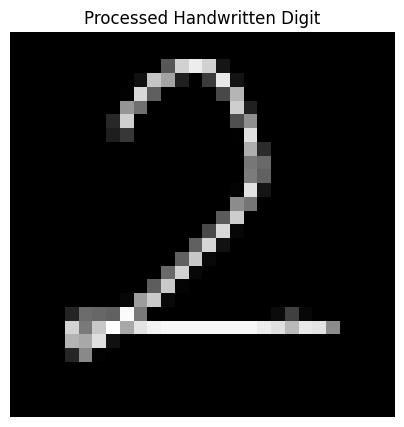

In [158]:
# Preprocess and plot the image 
digit2 = preprocess_handwritten_digit('handwritten_digit_two.jpg')

1/1 [==============================] - 0s 15ms/step
Predicted digit: 2
Confidence: 100.00%


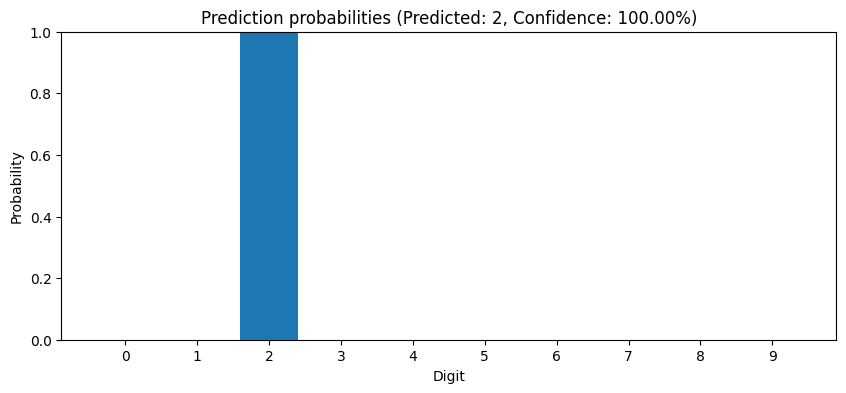

In [162]:
# Make a prediction and plot probabilities
predicted_digit, confidence, prediction = predict_digit(cnn_model, digit2)

Accurately predicted digit 2 with 100% confidence

### Handwritten Number 7

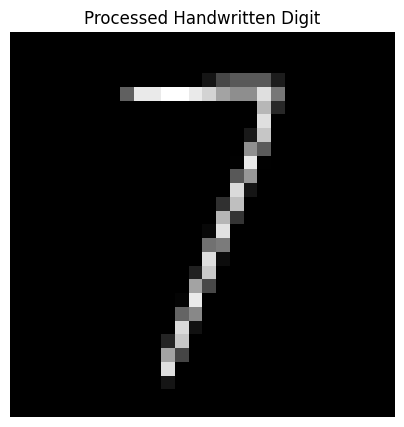

1/1 [==============================] - 0s 18ms/step
Predicted digit: 7
Confidence: 95.96%


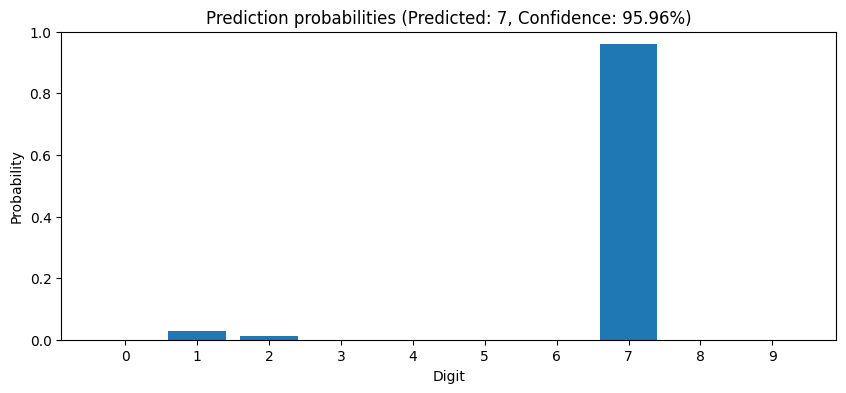

In [164]:
# Preprocess and plot the image 
digit7 = preprocess_handwritten_digit('handwritten_digit_seven.jpg')
# Make a prediction and plot probabilities
predicted_digit, confidence, prediction = predict_digit(cnn_model, digit7)

Accurately predicted digit 7 with 95.96% confidence, whereas the DNN could not even get it right and misclassify it as 1

### Handwritten Number 4

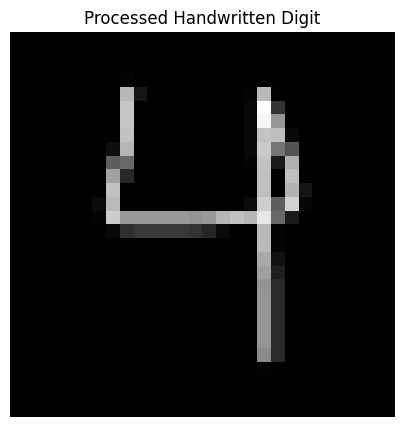

1/1 [==============================] - 0s 14ms/step
Predicted digit: 4
Confidence: 100.00%


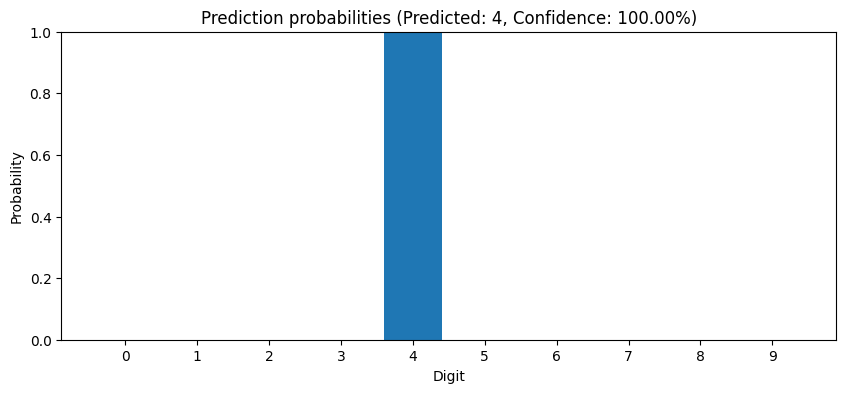

In [181]:
# Preprocess and plot the image 
digit4 = preprocess_handwritten_digit('handwritten_digit_four.jpg')
# Make a prediction and plot probabilities
predicted_digit, confidence, prediction = predict_digit(cnn_model, digit4)

In [ ]:
# Preprocess and plot the image 
digit = preprocess_handwritten_digit('handwritten_digit.jpg')
# Make a prediction and plot probabilities
predicted_digit, confidence, prediction = predict_digit(cnn_model, digit)

# Convolutional Neural Network for MNIST: Analysis and Conclusion

## Model Architecture and Training

The implemented CNN model for MNIST digit classification consists of:

1. **Three convolutional blocks**, each with increasing filter sizes (32 → 64 → 128) to progressively extract more complex features
2. **Max pooling layers** after each convolutional layer to reduce dimensionality and provide translation invariance
3. **Dropout regularization** (0.5) to prevent overfitting
4. **Dense layers** (128 neurons) following the convolutional feature extraction
5. **Adam optimizer** with default learning rate and sparse categorical cross-entropy loss

This architecture resulted in 241,546 trainable parameters, which is actually *fewer* than our previous DNN model (318,010 parameters) despite achieving significantly better performance.

## Performance Results

The CNN model achieved exceptional performance:
- **Training accuracy**: 99.63%
- **Validation accuracy**: 99.83% 
- **Test accuracy**: 99.30%

These results represent a substantial improvement over the DNN model, which achieved 98.36% test accuracy.

## Learning Behavior Analysis

Examining the training curves reveals several insights:

1. The CNN model converged much faster than the DNN, reaching high accuracy within just 3 epochs
2. The model showed minimal overfitting, with validation metrics closely tracking training metrics throughout
3. The use of early stopping and model checkpointing helped capture the optimal model weights
4. The loss curve shows steady improvement without plateauing, suggesting room for further optimization

## Handwritten Digit Tests

The most revealing aspect of the CNN's superiority came from testing on custom handwritten digits:

| Digit | CNN Prediction | CNN Confidence | DNN Prediction | DNN Confidence |
|-------|----------------|----------------|----------------|----------------|
| 2     | 2 (correct)    | 100.00%        | 2 (correct)    | 99.87%         |
| 7     | 7 (correct)    | 95.96%         | 1 (incorrect)  | 64.07%         |
| 4     | 4 (correct)    | 100.00%        | Not tested     | Not tested     |

The CNN correctly classified all handwritten digits with high confidence, including the digit '7' that the DNN model misclassified as '1'. This demonstrates the CNN's superior ability to:

1. Capture spatial relationships in the image data
2. Recognize key distinguishing features (like the horizontal stroke in '7')
3. Generalize to handwriting styles outside the training distribution

## Why CNNs Outperform DNNs for This Task

The results clearly demonstrate why CNNs are better suited for image classification tasks:

1. **Spatial hierarchy preservation**: CNNs maintain the spatial relationships between pixels, which is crucial for digit recognition
2. **Parameter efficiency**: The CNN achieved better results with fewer parameters (241K vs 318K)
3. **Translation invariance**: The pooling layers help recognize digits regardless of exact positioning
4. **Feature extraction**: Convolutional filters automatically learn relevant features like edges, corners, and curves
5. **Robustness to variations**: The CNN showed better generalization to handwritten digits outside the training distribution

## Real-World Implications

The dramatic difference in performance on the custom handwritten digits has important implications for real-world deployment:

1. A CNN model would be much more reliable for applications like:
   - Postal service digit recognition
   - Banking check processing
   - Form digitization
   - Handwritten note transcription

2. The DNN might perform well on standardized test data but would likely fail in production environments where handwriting styles vary significantly.

## Conclusion

While both models performed well on the MNIST test set, the CNN demonstrated superior performance across all metrics, particularly in its ability to generalize to real-world handwritten digits. This confirms that CNNs are the preferred architecture for image classification tasks, providing better accuracy with fewer parameters and greater robustness to variations in input data.

The modular implementation now allows for easy experimentation with different hyperparameters, preprocessing techniques, and model architectures, facilitating further improvements and adaptations to more challenging image recognition tasks.
